In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [12]:
# 고객별 구매일 모아서 다시만들기
data = 'C:/Users/user/Downloads/new_sales4.csv'
df_pro = pd.read_csv('C:/Users/user/Downloads/new_product5.csv',encoding='euc-kr')
df_member = pd.read_csv('C:/Users/user/Downloads/Member_data2.csv', encoding='euc-kr')
df_sales = pd.read_csv(data, low_memory=False, encoding='euc-kr')

In [13]:
# 월별 전체 매출
df2 = df_sales.copy()
df2['구매일'] = df_sales['구매일'].astype(str).apply(lambda x:x[:7])
df2.groupby('구매일')['결제금액'].agg(['sum','count'])


,sum,count
구매일,,
2019-01,88867985,4359
2019-02,136463219,7156
2019-03,161780826,9579
2019-04,179559469,8922
2019-05,213899693,8949
2019-06,228794478,10907
2019-07,291671879,14587
2019-08,272403200,12607
2019-09,265811765,12829


In [14]:
# 월별 신규방문자, 신규구매, 재구매
"""
신규구매, 재 구매의 경우 특정 간격(90 days)에 따라 달라져야함
ex) 90일 지나면 기존 구매 고객도 신규 고객 취급
"""

df_member['가입월']=df_member['고객번호'].apply(lambda x:str(x)[:6])
df_member = df_member[df_member['가입월'] != '201812']
df_member['가입월'].value_counts()

df_new = pd.DataFrame()
df_new['전체결제수'] = df_sales['구매월'].value_counts()
df_new = df_new.sort_index()
df_new = df_new.reset_index()
df_new = df_new.rename(columns = {'index':'월'})

In [15]:
## 최초 구매
### Frequency
df_frequency = pd.DataFrame(df_sales.groupby(['고객번호'])['구매일'].apply(list)).reset_index()
df_frequency['가입일'] = df_frequency['고객번호'].apply(lambda x:str(x)[:8])
df_frequency['구매금액'] = df_sales.groupby('고객번호')['구매금액'].apply(list).values
### Convert to Datetime
df_frequency['구매일'] = df_frequency['구매일'].apply(lambda x:list(map(lambda y:np.datetime64(y, 'D'), x)))

## 월별 최초구매(간격계산 후) 고객, 해당 고객이 구매한 매출
df_sales['구매월'] = df_sales['구매일'].apply(lambda x:str(x)[:7].replace('-',''))
df_sales['할인율'] = 1-(df_sales['결제금액']/df_sales['구매금액']).round(2)


In [16]:

def first_sales(month, drop_days=90, df_frequency=df_frequency, df_sales = df_sales):
    # 최초구매일 in 특정월
    # - 특정일 사이에 있는지
    tmp = df_sales[df_sales['구매월'] == month].groupby('고객번호')['구매일'].min().reset_index()
    tmp_cash = df_sales[df_sales['구매월'] == month].groupby('고객번호')[['구매금액', '결제금액']].sum().reset_index()
    tmp['최대기간'] = tmp['구매일'].apply(lambda x:str(np.datetime64(x, 'D')-drop_days))
    tmp = pd.merge(tmp, tmp_cash, on='고객번호')

    def customer_state(x, df_frequency=df_frequency):
        date_list = df_frequency[df_frequency['고객번호'] == x['고객번호']]['구매일'].values[0]
        # 신규, 복귀, 재구매
        if sum(date_list < np.datetime64(x['구매일'], 'D')) > 0: # 구매일 전에 구매 기록있음
            if sum((np.datetime64(x['최대기간'], 'D') <= date_list) & (np.datetime64(x['구매일'], 'D') > date_list)) > 0: # 그 구매가 3개월 이내임
                return (False, True) # 신규아님, 재구매
            else:
                return (False, False) # 신규아님, 재구매 X == 복귀
        else:
            return (True, False) # 신규, 재구매 X
    
    tmp2 = tmp.apply(lambda x:customer_state(x), axis=1)
    tmp = tmp.drop(['구매일', '최대기간'], axis=1)
    tmp['신규여부'] = tmp2.apply(lambda x:x[0])
    tmp['재구매여부'] = tmp2.apply(lambda x:x[1])

    return tmp

In [17]:
df_new['월'] = df_new['월'].astype(str)
customer_list = [first_sales(month=i, drop_days=90) for i in df_new['월']]

df_new['이용고객수'] = [len(i) for i in customer_list]
df_new['신규고객수'] = [sum(i['신규여부']) for i in customer_list]
df_new['재구매고객수'] = [sum(i['재구매여부']) for i in customer_list]
df_new['복귀고객수'] = [(i[['신규여부', '재구매여부']].sum(axis=1) == 0).sum() for i in customer_list]
## 복귀 고객의 금액은 빠져있음
df_new['신규_구매금액'] = [i[i.apply(lambda x:x['신규여부'] == True, axis=1)]['구매금액'].sum() for i in customer_list]
df_new['재_구매금액'] = [i[i.apply(lambda x:x['재구매여부'] == True, axis=1)]['구매금액'].sum() for i in customer_list]
df_new['재구매_평균금액'] = df_new['재_구매금액']/df_new['재구매고객수']
df_new['신규_평균금액'] = df_new['신규_구매금액']/df_new['신규고객수']

ta = [1-(df_new['재구매고객수'][i]/df_new['이용고객수'][i-3]) for i in range(3, len(df_new))]
for _ in range(3):
    ta.insert(0, 0)
df_new['이탈율'] = ta

In [21]:
df2 = df_sales.groupby('고객번호')['구매일'].apply(list)
df2.values[0]

sales_min = df_sales.groupby('고객번호')['구매일'].min().reset_index()

df_sales.groupby('구매월')['결제금액'].agg(['sum', 'count'])

df3 = df_sales.groupby('고객번호')['구매일'].min().apply(lambda x:str(x)[:7].replace('-',''))
df_new['최초구매월'] = df3.value_counts()

## 재구매 방문자 수
df_sales['구매일'] = df_sales['구매일'].astype('datetime64[D]')
g_sales = df_sales.groupby('고객번호')
### 2회이상 구매한 경우 Sales
df_sales2 = df_sales[df_sales['고객번호'].isin(g_sales['구매일'].count()[(g_sales['구매일'].count() > 1)].index)]




pandas.core.frame.DataFrame

In [30]:
df_sales2.reset_index(drop = True, inplace= True)
df_sales2['가입일자'] = 0

for i in range(len(df_sales2)):
    df_sales2['가입일자'][i] = str(df_sales2['고객번호'][i])[0:8]


C:\Users\user\AppData\Local\Temp\ipykernel_27408\254993610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales2['가입일자'] = 0
C:\Users\user\AppData\Local\Temp\ipykernel_27408\254993610.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales2['가입일자'][i] = str(df_sales2['고객번호'][i])[0:8]


In [31]:
df_sales2


,주문번호,구매일,배송시작일,배송완료일,구매시월령(수정),고객번호,구매금액,결제금액,물품대분류,상품명,수량추정,구매월,할인율,가입일자
0,201905052342970,2019-05-06,2019-05-07,2019-05-11,4.0,201812310749735,25800,16314,수유용품,더블하트 SofTouch 모유실감 젖꼭지 M (2입),2.000000,201905,0.37,20181231
1,202002203424450,2020-02-20,2020-02-21,2020-02-23,14.0,201812310749735,51200,37769,기저귀,NEW 하기스 맥스드라이 팬티 5단계 남아 80매(팬티형),1.155756,202002,0.26,20181231
2,201905092356247,2019-05-10,2019-05-11,2019-05-13,5.0,201812310749774,50640,39788,기저귀,하기스 에어솔솔 썸머기저귀 3단계 공용 144매(밴드형),1.000000,201905,0.21,20181231
3,201907282649358,2019-07-29,2019-07-30,2019-08-02,8.0,201812310749774,101280,76744,기저귀,[2019년형] 하기스 에어솔솔 썸머기저귀 3단계 공용 144매(밴드형),3.421622,201907,0.24,20181231
4,201901161908099,2019-01-17,2019-01-18,2019-01-20,NaN,201812310749783,6770,6029,생리대,디펜드 맘스 안심패드 30개입,1.000000,201901,0.11,20181231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154688,20200727062932-97104092254,2020-07-27,2020-07-28,2020-07-30,2.0,201912281057997,2600,2570,생리대,좋은느낌 순수 울트라 날개 대형 16개입 (EA),1.000000,202007,0.01,20191228
154689,201912283245106,2019-12-29,2019-12-30,2020-01-01,0.0,201912281058006,3000,3000,맘큐,맘큐 허그박스,1.000000,201912,0.00,20191228
154690,20200521172454-86563196093,2020-05-22,2020-05-23,2020-05-25,3.0,201912281058006,5900,5900,체험팩,NEW 하기스 맥스드라이 3단계 공용 20매(밴드형/체험팩) (EA),1.000000,202005,0.00,20191228
154691,201912283245152,2019-12-29,2019-12-30,2020-01-02,-3.0,201912281058012,3000,3000,맘큐,맘큐 허그박스,1.000000,201912,0.00,20191228


In [32]:
df_sales2['가입월'] = 0

for i in range(len(df_sales2)):
    df_sales2['가입월'][i] = str(df_sales2['고객번호'][i])[4:6]

C:\Users\user\AppData\Local\Temp\ipykernel_27408\3371568400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales2['가입월'] = 0
C:\Users\user\AppData\Local\Temp\ipykernel_27408\3371568400.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales2['가입월'][i] = str(df_sales2['고객번호'][i])[4:6]


In [33]:
df_sales2

,주문번호,구매일,배송시작일,배송완료일,구매시월령(수정),고객번호,구매금액,결제금액,물품대분류,상품명,수량추정,구매월,할인율,가입일자,가입월
0,201905052342970,2019-05-06,2019-05-07,2019-05-11,4.0,201812310749735,25800,16314,수유용품,더블하트 SofTouch 모유실감 젖꼭지 M (2입),2.000000,201905,0.37,20181231,12
1,202002203424450,2020-02-20,2020-02-21,2020-02-23,14.0,201812310749735,51200,37769,기저귀,NEW 하기스 맥스드라이 팬티 5단계 남아 80매(팬티형),1.155756,202002,0.26,20181231,12
2,201905092356247,2019-05-10,2019-05-11,2019-05-13,5.0,201812310749774,50640,39788,기저귀,하기스 에어솔솔 썸머기저귀 3단계 공용 144매(밴드형),1.000000,201905,0.21,20181231,12
3,201907282649358,2019-07-29,2019-07-30,2019-08-02,8.0,201812310749774,101280,76744,기저귀,[2019년형] 하기스 에어솔솔 썸머기저귀 3단계 공용 144매(밴드형),3.421622,201907,0.24,20181231,12
4,201901161908099,2019-01-17,2019-01-18,2019-01-20,NaN,201812310749783,6770,6029,생리대,디펜드 맘스 안심패드 30개입,1.000000,201901,0.11,20181231,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154688,20200727062932-97104092254,2020-07-27,2020-07-28,2020-07-30,2.0,201912281057997,2600,2570,생리대,좋은느낌 순수 울트라 날개 대형 16개입 (EA),1.000000,202007,0.01,20191228,12
154689,201912283245106,2019-12-29,2019-12-30,2020-01-01,0.0,201912281058006,3000,3000,맘큐,맘큐 허그박스,1.000000,201912,0.00,20191228,12
154690,20200521172454-86563196093,2020-05-22,2020-05-23,2020-05-25,3.0,201912281058006,5900,5900,체험팩,NEW 하기스 맥스드라이 3단계 공용 20매(밴드형/체험팩) (EA),1.000000,202005,0.00,20191228,12
154691,201912283245152,2019-12-29,2019-12-30,2020-01-02,-3.0,201912281058012,3000,3000,맘큐,맘큐 허그박스,1.000000,201912,0.00,20191228,12


In [50]:

data = 'C:/Users/user/Downloads/rfm.csv'
df = pd.read_csv(data, encoding='euc-kr', low_memory = False)
df['가입일'] = df['고객번호'].apply(lambda x:x[:8])

df = df.rename(columns = {'마지막 구매일' : '최근구매'})
df['최근구매'] = pd.to_datetime(df['최근구매'])

df['최근구매'] = df['최근구매'].apply(lambda x:np.datetime64(str(x).split(' ')[0], 'D'))
#df['마지막구매'] = df['마지막구매'].apply(lambda x:x.strftime('%Y-%m-%d'))

last_day = np.datetime64('2020-08-07', 'D')
df['최근구매'] = df['최근구매'].apply(lambda x:last_day-x)/np.timedelta64(1, 'D')

df.columns

Index(['고객번호', '첫 구매일', '최근구매', '마지막 구매 후 경과 일자', '구매 횟수', '평균 구매 주기', '결제금액',
       '구매금액', '가입일'],
      dtype='object')

In [54]:
df['가입월'] = 0
for i in range(len(df)):
    df['가입월'][i] = str(df['가입일'][i])[4:6]
    

C:\Users\user\AppData\Local\Temp\ipykernel_27408\3126789749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['가입월'][i] = str(df['가입일'][i])[4:6]


In [58]:
df.sort_values('가입월')

,고객번호,첫 구매일,최근구매,마지막 구매 후 경과 일자,구매 횟수,평균 구매 주기,결제금액,구매금액,가입일,첫 구매월,가입월
6546,201901250774154,2019-10-28,122.0,122,8,23,180269,265400,20190125,10,01
6575,201901250774261,2019-02-05,23.0,23,13,43,333646,462040,20190125,02,01
6576,201901250774263,2019-10-25,282.0,282,4,1,49132,76050,20190125,10,01
6577,201901250774266,2019-01-25,560.0,560,1,0,28152,31600,20190125,01,01
6578,201901250774267,2019-09-28,314.0,314,1,0,5841,7280,20190125,09,01
...,...,...,...,...,...,...,...,...,...,...,...
63008,201912131044323,2019-12-21,230.0,230,1,0,34799,52320,20191213,12,12
63009,201912131044330,2019-12-14,237.0,237,1,0,3000,3000,20191213,12,12
63010,201912131044340,2020-05-17,82.0,82,1,0,25778,48900,20191213,05,12
62997,201912131044287,2019-12-21,191.0,191,2,39,20121,30400,20191213,12,12


array([[<AxesSubplot: title={'center': '01'}>,
        <AxesSubplot: title={'center': '02'}>,
        <AxesSubplot: title={'center': '03'}>],
       [<AxesSubplot: title={'center': '04'}>,
        <AxesSubplot: title={'center': '05'}>,
        <AxesSubplot: title={'center': '06'}>],
       [<AxesSubplot: title={'center': '07'}>,
        <AxesSubplot: title={'center': '08'}>,
        <AxesSubplot: title={'center': '09'}>],
       [<AxesSubplot: title={'center': '10'}>,
        <AxesSubplot: title={'center': '11'}>,
        <AxesSubplot: title={'center': '12'}>]], dtype=object)

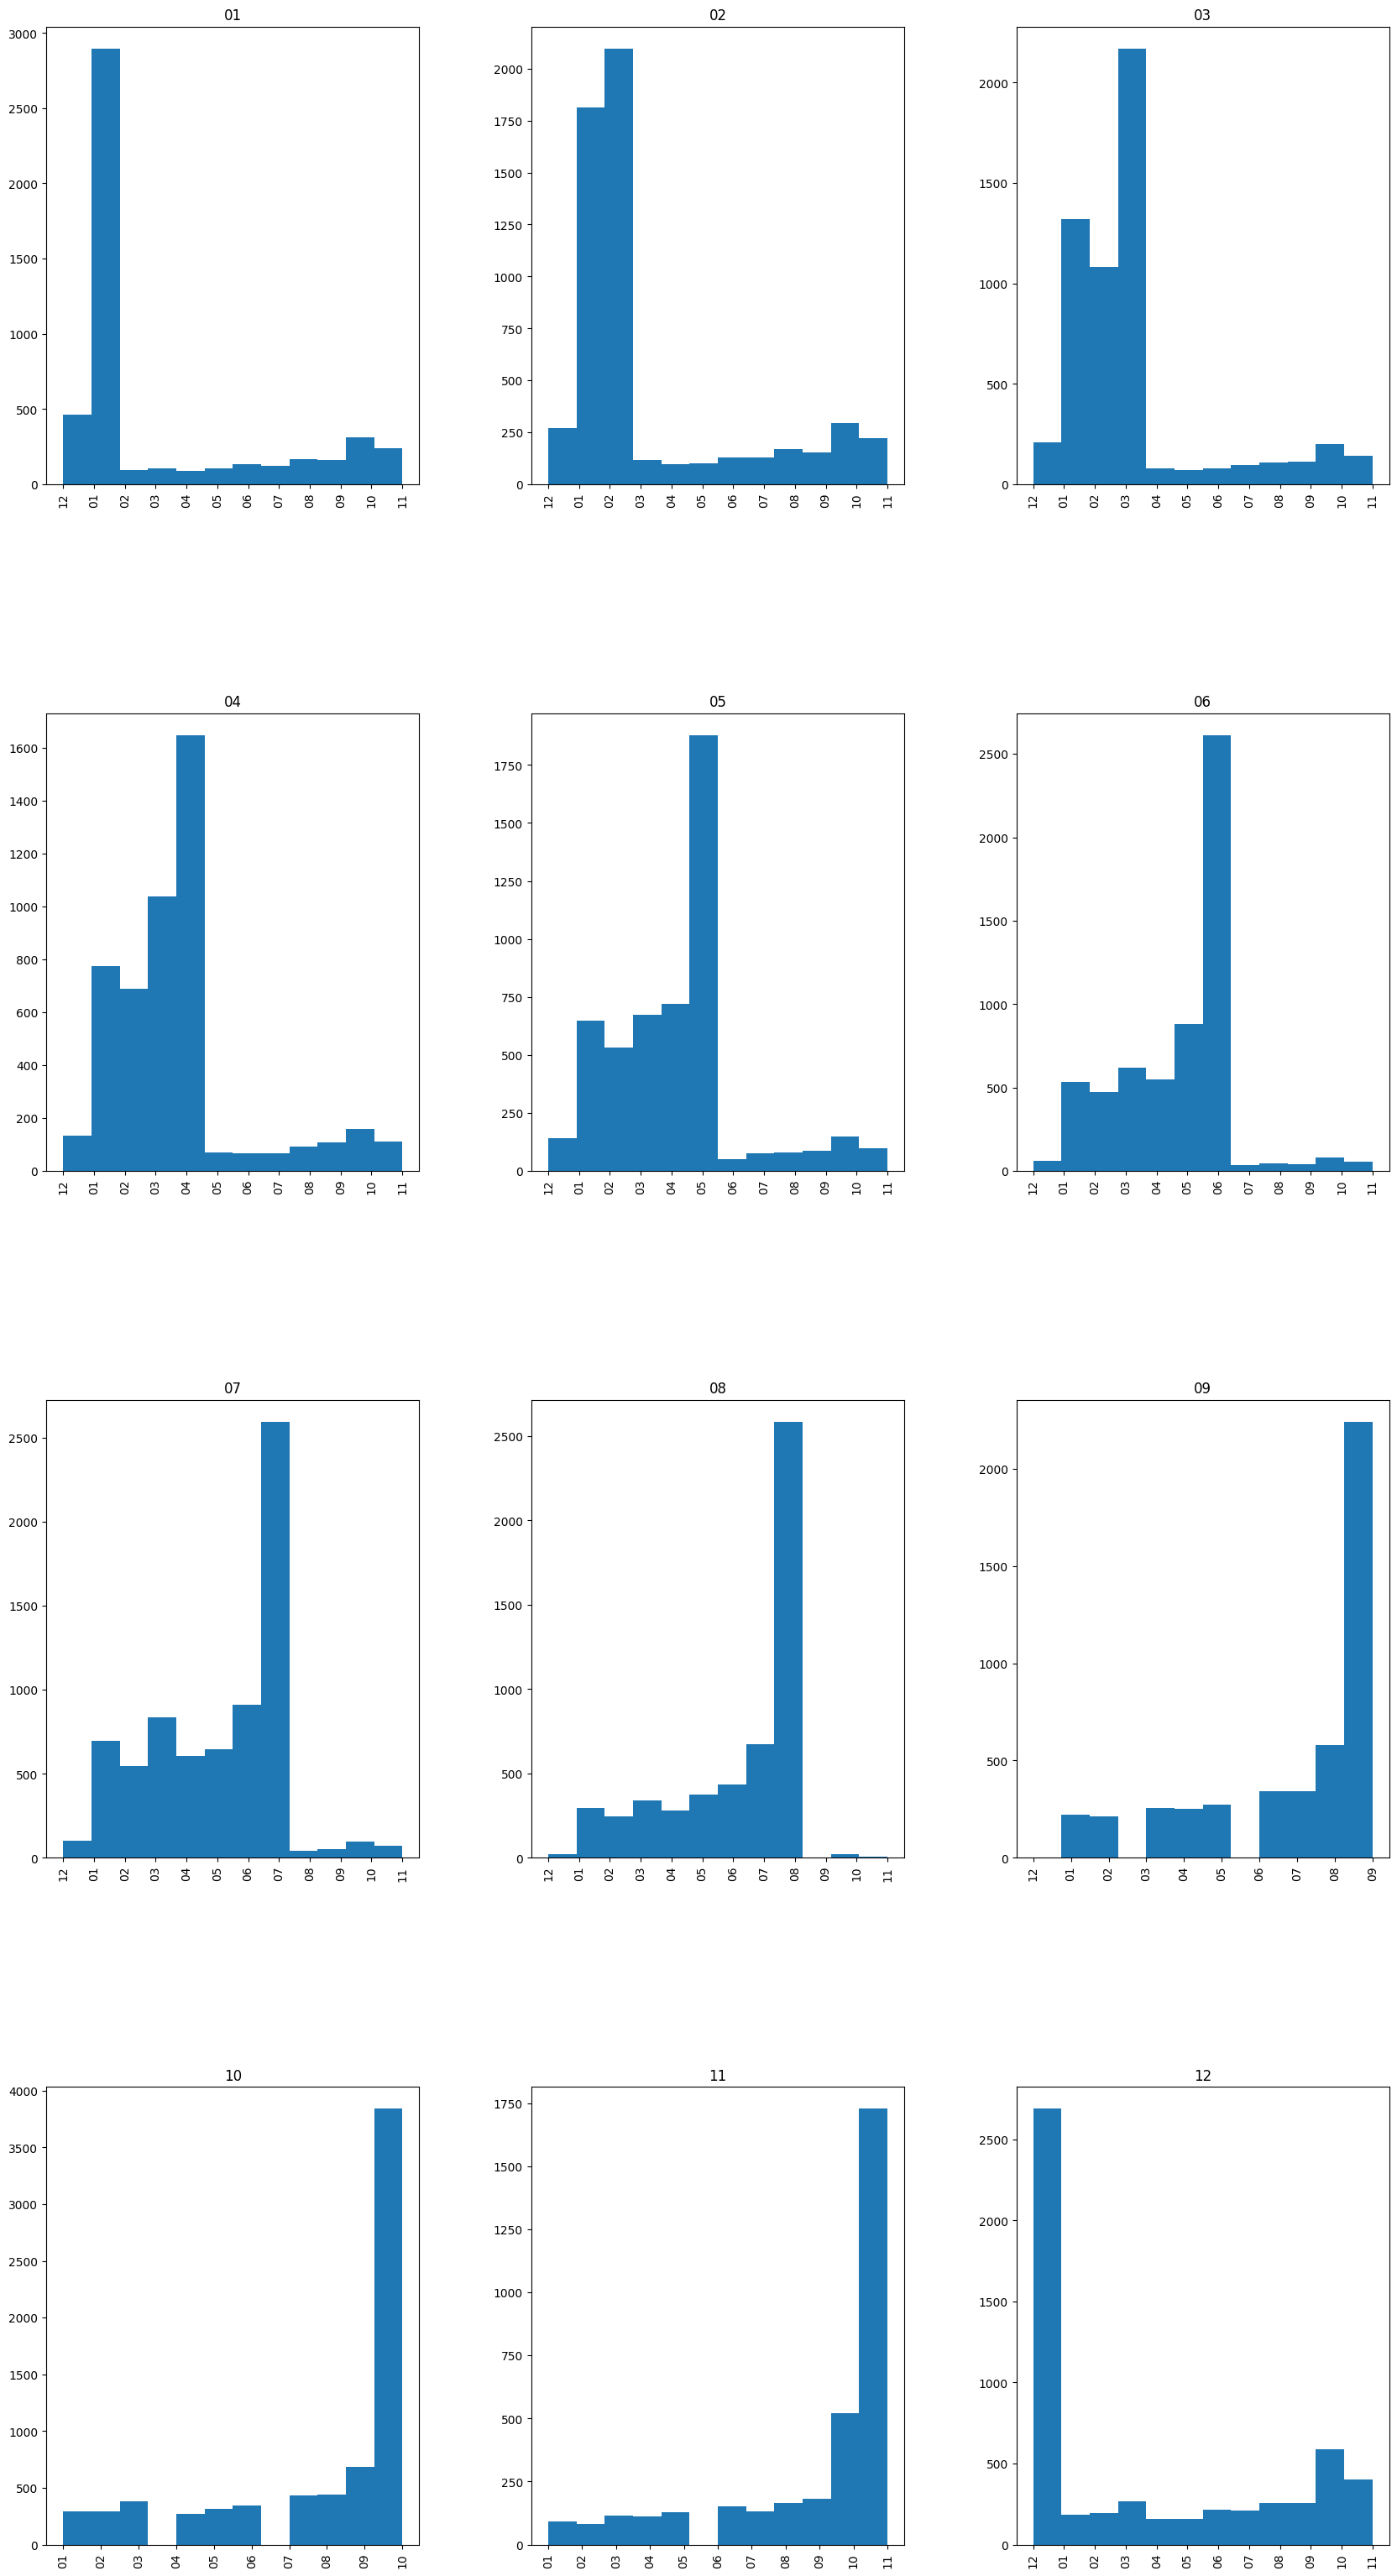

In [59]:
df.hist('가입월','첫 구매월',bins= 12,figsize=(20,40))


In [60]:
df

,고객번호,첫 구매일,최근구매,마지막 구매 후 경과 일자,구매 횟수,평균 구매 주기,결제금액,구매금액,가입일,첫 구매월,가입월
0,201812310749735,2019-05-06,169.0,169,2,290,54083,77000,20181231,05,12
1,201812310749771,2019-05-13,452.0,452,1,0,47922,59520,20181231,05,12
2,201812310749774,2019-05-10,375.0,375,2,80,116532,151920,20181231,05,12
3,201812310749780,2019-01-30,555.0,555,1,0,19900,27920,20181231,01,12
4,201812310749784,2019-04-29,15.0,15,8,64,166877,270840,20181231,04,12
...,...,...,...,...,...,...,...,...,...,...,...
65727,20200708231025349606,2020-07-09,29.0,29,1,0,28102,49900,20200708,07,07
65728,20200721194641507158,2020-08-01,6.0,6,1,0,25480,25480,20200721,08,07
65729,20200724095212627384,2020-07-24,14.0,14,1,0,0,0,20200724,07,07
65730,20200724113017315991,2020-07-24,14.0,14,1,0,9240,11700,20200724,07,07
